# Data Loading, Cleaning & Merging

### Importazione Librerie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

### Caricamento Dati

In [3]:
CSV_files = {
    "customers":           r"dataset/olist_customers_dataset.csv",
    "geolocation_dataset": r"dataset/olist_geolocation_dataset.csv",
    "order_items":         r"dataset/olist_order_items_dataset.csv",
    "order_payments":      r"dataset/olist_order_payments_dataset.csv",
    "order_review":        r"dataset/olist_order_reviews_dataset.csv",
    "order_dataset":       r"dataset/olist_orders_dataset.csv",
    "list_product":        r"dataset/olist_products_dataset.csv",
    "list_seller":         r"dataset/olist_sellers_dataset.csv",
    "product_category":    r"dataset/product_category_name_translation.csv"
}

dataframes = {name: pd.read_csv(path) for name, path in CSV_files.items()}

df_customers           = dataframes["customers"]
df_orders_items        = dataframes["order_items"]
df_order_payments      = dataframes["order_payments"]
df_order_review        = dataframes["order_review"]
df_order_dataset       = dataframes["order_dataset"]
df_list_product        = dataframes["list_product"]
df_list_seller         = dataframes["list_seller"]
df_product_category    = dataframes["product_category"]
df_geolocation_dataset = dataframes["geolocation_dataset"]

### Analisi Preliminare

In [4]:
# Stampa un riepilogo di ogni csv con la sua shape e i missing values.
def quick_overview(df, name):
    print(f"{name}")
    print(f"Shape: {df.shape}")
    nulls = df.isna().sum()
    nulls = nulls[nulls > 0]
    if len(nulls) > 0:
        print(f"Valori nulli:\n{nulls.to_string()}\n")
    else:
        print("Nessun valore nullo\n")

for name, df in dataframes.items():
    quick_overview(df, name)

customers
Shape: (99441, 5)
Nessun valore nullo

geolocation_dataset
Shape: (1000163, 5)
Nessun valore nullo

order_items
Shape: (112650, 7)
Nessun valore nullo

order_payments
Shape: (103886, 5)
Nessun valore nullo

order_review
Shape: (99224, 7)
Valori nulli:
review_comment_title      87656
review_comment_message    58247

order_dataset
Shape: (99441, 8)
Valori nulli:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965

list_product
Shape: (32951, 9)
Valori nulli:
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2

list_seller
Shape: (3095, 4)
Nessun valore nullo

product_category
Shape: (71, 2)
Nessun valore nullo



### PULIZIA: df_list_product

In [5]:
# 1) Droppiamo le colonne (peso, misure)
# 2) Droppiamo i 610 prodotti senza categoria (< 2% del totale):
#    verranno esclusi anche dagli altri df.
# 3) Uniamo la traduzione inglese della categoria.

# 1
df_list_product = df_list_product.drop(
    columns=['product_name_lenght', 'product_width_cm',
             'product_height_cm', 'product_length_cm', 'product_weight_g']
)

# 2
# Salviamo gli id dei prodotti senza categoria per filtrare order_items dopo
product_id_nan = df_list_product[df_list_product['product_category_name'].isna()]
product_id_to_delete = product_id_nan['product_id'].to_numpy()
df_list_product = df_list_product.dropna(subset=['product_category_name'])

# 3
df_list_product = (
    df_list_product
    .merge(df_product_category, on='product_category_name', how='left')
    .drop(columns=['product_category_name'])
)

df_list_product.info()
df_list_product.sample(2)

<class 'pandas.DataFrame'>
RangeIndex: 32341 entries, 0 to 32340
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32341 non-null  str    
 1   product_description_lenght     32341 non-null  float64
 2   product_photos_qty             32341 non-null  float64
 3   product_category_name_english  32328 non-null  str    
dtypes: float64(2), str(2)
memory usage: 1010.8 KB


,product_id,product_description_lenght,product_photos_qty,product_category_name_english
7632,0df595995d2f55005a3de2b62ca97189,72.0,1.0,fashion_bags_accessories
1347,ace0a62915c59a40d45b2597336c68d7,98.0,4.0,telephony


In [6]:
df_list_product['product_photos_qty'].describe()

count    32341.000000
mean         2.188986
std          1.736766
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: product_photos_qty, dtype: float64

In [7]:
df_list_product['product_description_lenght'].describe()

count    32341.000000
mean       771.495285
std        635.115225
min          4.000000
25%        339.000000
50%        595.000000
75%        972.000000
max       3992.000000
Name: product_description_lenght, dtype: float64

### PULIZIA: df_orders_items

In [8]:
# 1) Escludiamo gli items con product_id in product_id_to_delete
# 2) Convertiamo shipping_limit_date in datetime

# 1
df_orders_items = (
    df_orders_items[~df_orders_items['product_id'].isin(product_id_to_delete)]
    .copy()
    .reset_index(drop=True)
)

# 2
df_orders_items['shipping_limit_date'] = pd.to_datetime(
    df_orders_items['shipping_limit_date']
)

df_orders_items.info()
df_orders_items.sample(2)

<class 'pandas.DataFrame'>
RangeIndex: 111047 entries, 0 to 111046
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             111047 non-null  str           
 1   order_item_id        111047 non-null  int64         
 2   product_id           111047 non-null  str           
 3   seller_id            111047 non-null  str           
 4   shipping_limit_date  111047 non-null  datetime64[us]
 5   price                111047 non-null  float64       
 6   freight_value        111047 non-null  float64       
dtypes: datetime64[us](1), float64(2), int64(1), str(3)
memory usage: 5.9 MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
50990,75a274082b03938965592307afe46ae2,1,36ea81e90d1292dcdc3ad8abb09c20fe,a420f60ff1aa9acc80d0e42959f2b313,2018-01-12 17:09:28,73.5,17.76
108722,fa939fb695a0a458a472916809af767d,1,d285360f29ac7fd97640bf0baef03de0,4869f7a5dfa277a7dca6462dcf3b52b2,2018-03-21 20:48:41,298.0,19.97


### PULIZIA: df_order_dataset

In [9]:
# 1) convertire tutte le colonne data in datetime

# DA RIVEDERE INSIEME SE POSSONO ESSERE UTILI
# 2) delivery_delay_days : differenza tra consegna effettiva e stimata
#    (positivo = in ritardo, negativo = in anticipo)
#    actual_delivery_days: giorni totali dall'acquisto alla consegna

# 1
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in date_cols:
    df_order_dataset[col] = pd.to_datetime(df_order_dataset[col])

# 2
df_order_dataset['delivery_delay_days'] = (
    df_order_dataset['order_delivered_customer_date'] -
    df_order_dataset['order_estimated_delivery_date']
).dt.days
df_order_dataset['actual_delivery_days'] = (
    df_order_dataset['order_delivered_customer_date'] -
    df_order_dataset['order_purchase_timestamp']
).dt.days

df_order_dataset.info()
df_order_dataset.sample(2)

<class 'pandas.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  str           
 1   customer_id                    99441 non-null  str           
 2   order_status                   99441 non-null  str           
 3   order_purchase_timestamp       99441 non-null  datetime64[us]
 4   order_approved_at              99281 non-null  datetime64[us]
 5   order_delivered_carrier_date   97658 non-null  datetime64[us]
 6   order_delivered_customer_date  96476 non-null  datetime64[us]
 7   order_estimated_delivery_date  99441 non-null  datetime64[us]
 8   delivery_delay_days            96476 non-null  float64       
 9   actual_delivery_days           96476 non-null  float64       
dtypes: datetime64[us](5), float64(2), str(3)
memory usage: 7.6 MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay_days,actual_delivery_days
84385,13fba1a42e51558ae3e8a86e0bbd9dd3,c603da2cef9367d777d325182a234d85,delivered,2017-10-09 15:14:31,2017-10-10 06:32:11,2017-10-11 11:10:40,2017-10-18 18:09:21,2017-11-03,-16.0,9.0
9687,5c966af20bdad2fc92140be537e76912,f6b6b5ca3111887288b23cdeb52d28b6,delivered,2017-08-17 08:04:24,2017-08-18 02:35:29,2017-08-24 21:13:29,2017-09-06 21:56:56,2017-09-15,-9.0,20.0


### PULIZIA: df_order_review

In [10]:
# 1) convertire tutte le colonne data in datetime

# DA RIVEDERE INSIEME
# Alcuni ordini hanno più di una review.
# Teniamo solo l'ultima review per ordine (la più recente).
# Possiamo rimuovere le colonne relative ai commenti o vi interessano?

# 1
df_order_review['review_creation_date'] = pd.to_datetime(
    df_order_review['review_creation_date']
)

df_order_review.sample(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
96530,623eaa92f6812f4859e6107d83af6fbd,8730eb6033096bc99877b2f10d4de04a,5,NaN,NaN,2017-12-12,2017-12-13 15:56:40
67743,2e6627dd45aaea3d80efa214683f1f6a,0aec87a19cce94ceda3bce4b605d9423,5,NaN,NaN,2018-03-22,2018-03-22 18:56:54


### PULIZIA: df_order_payments

In [11]:
df_order_payments.info()

<class 'pandas.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  str    
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  str    
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), str(2)
memory usage: 4.0 MB


In [12]:
len(df_order_payments['order_id'])

103886

In [13]:
len(df_order_payments['order_id'].unique())

99440

In [14]:
# DA RIVEDERE INSIEME
# Per un ordine ci sono diverse righe di pagamenti
# Aggreghiamo per order_id sommando il valore totale
# Non credo che ci servirà il tipo di pagamento (payment_type)
# nemmeno li numero di rate del pagamento (payment_installments)
# per ora le ho lasciate

df_order_payments = (
    df_order_payments
    .groupby('order_id', as_index=False)
    .agg(
        total_payment_value  = ('payment_value','sum'),
        payment_installments = ('payment_installments', 'max'),
        payment_type         = ('payment_type', 'first')
    )
)

df_order_payments.sample(2)

,order_id,total_payment_value,payment_installments,payment_type
69362,b2e7423926537e79e712ccf08ce1a53f,113.79,3,voucher
12495,2036e60f61d651518a111dfb2ae5a411,74.16,1,boleto


5) PULIZA PRELIMINARE DATAFRAME geolocation E RAGGRUPAMENTO PER ZIP CODE

In [16]:
df_geolocation_dataset.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
215406,8740,-23.544447,-46.212923,mogi das cruzes,SP
342564,14870,-21.252448,-48.326792,jaboticabal,SP
313038,13573,-22.061863,-47.895974,sao carlos,SP


In [17]:
df_list_seller=df_list_seller.rename(columns={'seller_zip_code_prefix':'geolocation_zip_code_prefix'})

In [18]:
df_list_seller.sample(3)

,seller_id,geolocation_zip_code_prefix,seller_city,seller_state
1599,834f3294fba9f932f56edc879193f925,14808,araraquara,SP
1423,3f3486b61f45078d4f31ee5e43d8c5bb,3035,sao paulo,SP
88,674207551483fec113276b67b0d871ff,18040,sorocaba,SP


In [19]:
df_customers=df_customers.rename(columns={'customer_zip_code_prefix':'geolocation_zip_code_prefix'})

In [20]:
df_customers.sample(3)

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state
21978,bab006f240ef438b5e724e3df1aefeea,791a267787e75fd37f4aef4e9868cfe4,11355,sao vicente,SP
70214,8b086b22bcef7fdfe416c88b5437c400,b9aa10bea53310b8c03c975afbeb2164,37200,lavras,MG
73594,b6102fd2d657e6c43033cf2a70270ca2,09cd73b13f103e47ce13675b4a4b36f3,78049,cuiaba,MT


### TEST DI POTESI: verificare se un prodotto con una certa descrizione ha vendite più alte

Ipotesi nulla H0: la lunghezza della descrizione non influenza il numero di vendite.

Ipotesi alternativa H1: la lunghezza della descrizione influenza il numero di vendite

Effettuo un permutation test assegnado alfa del 5% 

In [22]:
product_counts = df_orders_items.groupby("product_id").size().reset_index(name="sales_count")
product_counts['sales_count'].describe()
#conteggio delle vendite per ogni prodotto

count    32341.000000
mean         3.433629
std         10.651372
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        527.000000
Name: sales_count, dtype: float64

In [23]:
df_list_product=df_list_product[['product_id','product_description_lenght','product_category_name_english']]

In [24]:
product_counts

,product_id,sales_count
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32336,fff6177642830a9a94a0f2cba5e476d1,2
32337,fff81cc3158d2725c0655ab9ba0f712c,1
32338,fff9553ac224cec9d15d49f5a263411f,1
32339,fffdb2d0ec8d6a61f0a0a0db3f25b441,5


In [25]:
df_list_product.sample(2)

,product_id,product_description_lenght,product_category_name_english
24862,14f964bb089089d5e114cdaf786ce1b9,251.0,home_appliances
15690,8f3a83d431c7066aabd357f3ad3590a8,1978.0,perfumery


In [27]:
df_test = product_counts.merge(df_list_product, on="product_id", how="left")
df_test=df_test.drop(['product_category_name_english'],axis=1)
df_test['product_description_lenght'].describe()#visualizzo la mediana da usare per dividerla nei due gruppi

count    32341.000000
mean       771.495285
std        635.115225
min          4.000000
25%        339.000000
50%        595.000000
75%        972.000000
max       3992.000000
Name: product_description_lenght, dtype: float64

In [29]:
median_length=595.000000

In [30]:
short = df_test[df_test["product_description_lenght"] <= median_length]["sales_count"].values
long  = df_test[df_test["product_description_lenght"] > median_length]["sales_count"].values
#creazione ei due gruppi

In [49]:
mu_long = np.mean(long)
mu_short = np.mean(short)

obs_diff = mu_long - mu_short   
print(obs_diff)#la differenza fra le medie è di 0.1097

0.10972710690520548


In [48]:
all_sales = np.concatenate([short, long])
n_short = len(short)
# dimensioen del gruppo

In [46]:
n_permutations = 10000
perm_diffs = []

for i in range(n_permutations):
    
    shuffled_sales = np.random.permutation(all_sales)
    
    perm_short = shuffled_sales[:n_short]
    perm_long  = shuffled_sales[n_short:]
    
    mu_diff_temp = perm_long.mean() - perm_short.mean()
    
    perm_diffs.append(mu_diff_temp)

In [ ]:
perm_diffs = np.array(perm_diffs)

p_value = (np.sum(np.abs(perm_diffs) >= abs(obs_diff)) + 1) / (n_permutations + 1)

print("p-value:", p_value)


p-value: 0.36036396360363965


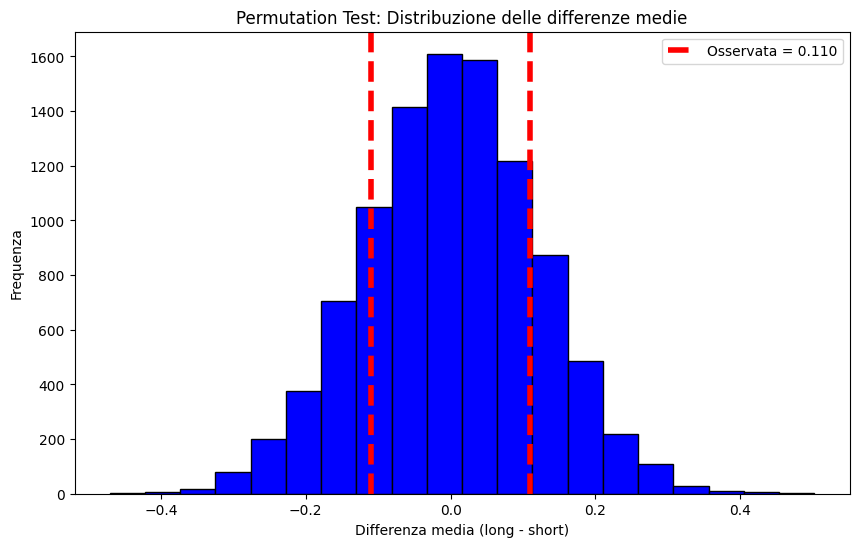

In [55]:
perm_diffs = np.array(perm_diffs)

plt.figure(figsize=(10,6))

# Istogramma delle differenze permutate
plt.hist(perm_diffs, bins=20, color='blue', edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=4, label=f'Osservata = {obs_diff:.3f}')
plt.axvline(-obs_diff, color='red', linestyle='dashed', linewidth=4)  # per test a due code

plt.title("Permutation Test: Distribuzione delle differenze medie")
plt.xlabel("Differenza media (long - short)")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

ACCETTIAMO L'IPOTESI NULLA-la lunghezza della descrizione non ha effetto sulle vendite.